In [1]:
%pip install albumentations datasets > /dev/null

In [2]:
# Import necessary libraries
import os
import sys
import gzip
import struct
from typing import List

import albumentations as albu  # Library for image augmentation
import cv2  # OpenCV library for image processing
import numpy as np
from tqdm import tqdm  # Library for progress bars

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader  # PyTorch utilities for data handling
import torchvision.models as models  # Pre-trained models provided by PyTorch

from datasets import load_dataset  # Custom function to load dataset

import matplotlib.pyplot as plt  # Library for plotting graphs and images

In [3]:
torch.manual_seed(42)  # Set random seed for reproducibility

## Dataset - [Tiny ImageNet](https://huggingface.co/datasets/zh-plus/tiny-imagenet)


In [4]:
# Load the dataset using the load_dataset function with parameters "frgfm/imagenette" and "320px".
# The "frgfm/imagenette" dataset is being loaded with images resized to 320 pixels.
dataset = load_dataset("frgfm/imagenette", "320px")

# Define the number of labels in the dataset.
num_labels = 10

# Print the dataset object.
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

imagenette.py:   0%|          | 0.00/5.31k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9469
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3925
    })
})

In [5]:
# Access the training split of the dataset using the key "train".
# Then, access the 124th sample (indexing is 0-based) within the training split.
# Retrieve the image data associated with the sample.
image_data = dataset["train"][123]["image"]

In [6]:
class HuggingFaceDataset(Dataset):
    """
    Define a custom dataset class named HuggingFaceDataset inheriting from the PyTorch Dataset class.
    """
    def __init__(self, dataset: Dataset, augmentations: albu.Compose) -> None:
        # Constructor method to initialize the dataset and augmentation transformations.
        self.dataset = dataset  # Store the input dataset
        self.augs = augmentations  # Store the augmentation transformations

    def __len__(self) -> int:
        # Override the len method to return the length of the dataset.
        return len(self.dataset)

    def __getitem__(self, index) -> tuple:
        # Override the getitem method to retrieve a sample from the dataset.
        sample = self.dataset[index]  # Get the sample at the specified index from the dataset

        # Convert the image to RGB format if it's not already in that format
        image = sample["image"].convert("RGB")

        # Apply the specified augmentations to the image
        image = self.augs(image=np.array(image))["image"]

        # Convert the augmented image to a PyTorch tensor and permute its dimensions
        image = torch.from_numpy(image).permute(2, 0, 1)

        # Convert the label to a PyTorch LongTensor
        label = torch.LongTensor([sample["label"]])

        # Return the augmented image and its corresponding label as a tuple
        return image, label


In [7]:
# Set the batch size for training
batch_size = 32

# Define the input shape for the images (height, width).
# NOTE: To speed up training, you can decrease the input shape, but it may affect the final performance.
input_shape = (224, 224)

# Set the number of workers for data loading to be the number of available CPU cores
workers = os.cpu_count()

# Define the augmentation transformations for training images
# TODO: optional, play with augmentations
train_augs = albu.Compose([
    albu.Resize(input_shape[0], input_shape[1]),
    albu.HorizontalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.2),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Create a DataLoader for training data using the defined augmentations
train_loader = DataLoader(
    HuggingFaceDataset(dataset['train'], train_augs),
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

# Define the augmentation transformations for validation images
valid_augs = albu.Compose([
    albu.Resize(input_shape[0], input_shape[1]),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Create a DataLoader for validation data using the defined augmentations
valid_loader = DataLoader(
    HuggingFaceDataset(dataset['validation'], valid_augs),
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers
)


In [8]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    """
    Function to train the model for one epoch.

    Args:
    - model: The neural network model to be trained.
    - loader: DataLoader object for loading the training data.
    - criterion: Loss function criterion.
    - optimizer: Optimizer for updating model parameters.
    - device: Device to run the model on (default is "cpu").
    - verbose: If True, print progress during training.

    Returns:
    - logs: Dictionary containing training statistics.
    """
    # TODO: complete training function
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    logs = {
        "loss": running_loss / len(loader),
        "accuracy": correct / total,
    }
    if verbose:
        print(f"Train Loss: {logs['loss']:.4f}, Train Accuracy: {logs['accuracy']:.4f}")
    return logs

In [9]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    """
    Function to evaluate the model on the validation or test set.

    Args:
    - model: The neural network model to be evaluated.
    - loader: DataLoader object for loading the validation or test data.
    - criterion: Loss function criterion.
    - device: Device to run the model on (default is "cpu").
    - verbose: If True, print evaluation results.

    Returns:
    - logs: Dictionary containing evaluation statistics.
    """
    # TODO: complete evaluation function
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device).squeeze()

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    logs = {
        "eval_loss": running_loss / len(loader),
        "accuracy": correct / total,
    }
    if verbose:
        print(f"Validation Loss: {logs['eval_loss']:.4f}, Validation Accuracy: {logs['accuracy']:.4f}")
    return logs

In [ ]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")

# TODO: Find a model that gives the best score.
# Here, a pre-trained ResNet50 model is used as a starting point.
# You may experiment with other pre-trained models available in torchvision.models.
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  # Load pre-trained ResNet18 model
model.fc = nn.Linear(model.fc.in_features, num_labels)  # Replace the fully connected layer with new output size
model = model.to(device)  # Move the model to the specified device (CPU or GPU)

print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Define the optimizer for updating model parameters
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()


NameError: name 'torch' is not defined

In [ ]:
n_epochs = 20  # Number of epochs for training

train_losses = []  # List to store training losses for each epoch
train_accuracies = []  # List to store training accuracies for each epoch

valid_losses = []  # List to store validation losses for each epoch
valid_accuracies = []  # List to store validation accuracies for each epoch

# Loop through each epoch
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    # Train the model for one epoch and collect training statistics
    train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["loss"]))
    train_accuracies.append(np.mean(train_logs["accuracy"]))
    print("      loss:", train_losses[-1])
    print("  accuracy:", train_accuracies[-1])

    # Evaluate the model on the validation set and collect evaluation statistics
    valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["eval_loss"]))  # Append the validation loss for the epoch
    valid_accuracies.append(np.mean(valid_logs["accuracy"]))  # Append the validation accuracy for the epoch
    print("      loss:", valid_losses[-1])  # Print the validation loss for the epoch
    print("  accuracy:", valid_accuracies[-1])  # Print the validation accuracy for the epoch



Epoch  1/20


Train Loss: 0.4911, Train Accuracy: 0.8631
      loss: 0.49113486420262503
  accuracy: 0.8631323265392333


Validation Loss: 0.8743, Validation Accuracy: 0.7839
      loss: 0.8742674837585508
  accuracy: 0.7839490445859872

Epoch  2/20


Training:  30%|██▉       | 88/296 [32:35<1:16:17, 22.01s/it]

In [ ]:
# Create a figure with two subplots side by side
fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

# Plot the training and validation losses on the first subplot (axes[0])
axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")  # Plot training losses
axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")  # Plot validation losses
axes[0].legend(["train", "validation"])  # Add legend to distinguish between training and validation losses
axes[0].set_title("Loss")  # Set title for the subplot as "Loss"
axes[0].grid()  # Add grid lines to the plot

# Plot the training and validation accuracies on the second subplot (axes[1])
axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")  # Plot training accuracies
axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")  # Plot validation accuracies
axes[1].legend(["train", "validation"])  # Add legend to distinguish between training and validation accuracies
axes[1].set_title("Accuracy")  # Set title for the subplot as "Accuracy"
axes[1].grid();  # Add grid lines to the plot


Epoch  1/20


Train Loss: 0.6320, Train Accuracy: 0.8081
      Train loss: 0.6319743885683853
  Train accuracy: 0.8081106769458232


Validation Loss: 0.6633, Validation Accuracy: 0.8041
Validation loss: 0.6632978607241701
Validation accuracy: 0.8040764331210191

Epoch  2/20


Train Loss: 0.4239, Train Accuracy: 0.8652
      Train loss: 0.4238967430098234
  Train accuracy: 0.8652444819938747


Validation Loss: 3.7799, Validation Accuracy: 0.4443
Validation loss: 3.7798979576644904
Validation accuracy: 0.4443312101910828

Epoch  3/20


Train Loss: 0.3307, Train Accuracy: 0.8962
      Train loss: 0.33073439091645385
  Train accuracy: 0.8961875594043721


Validation Loss: 0.4378, Validation Accuracy: 0.8675
Validation loss: 0.4378235680391876
Validation accuracy: 0.867515923566879

Epoch  4/20


Train Loss: 0.2730, Train Accuracy: 0.9154
      Train loss: 0.2729633593101155
  Train accuracy: 0.9154081740416095


Validation Loss: 0.7162, Validation Accuracy: 0.8018
Validation loss: 0.7161672696366157
Validation accuracy: 0.8017834394904458

Epoch  5/20


Train Loss: 0.2308, Train Accuracy: 0.9249
      Train loss: 0.23082493903820175
  Train accuracy: 0.9249128735874961


Validation Loss: 0.2994, Validation Accuracy: 0.9037
Validation loss: 0.29938429340954903
Validation accuracy: 0.9036942675159235

Epoch  6/20


Train Loss: 0.1760, Train Accuracy: 0.9427
      Train loss: 0.17604452965630069
  Train accuracy: 0.9426549794064844


Validation Loss: 0.5494, Validation Accuracy: 0.8632
Validation loss: 0.5494365029328511
Validation accuracy: 0.8631847133757962

Epoch  7/20


Train Loss: 0.1995, Train Accuracy: 0.9376
      Train loss: 0.19954077337516118
  Train accuracy: 0.9375858063153448


Validation Loss: 0.5487, Validation Accuracy: 0.8586
Validation loss: 0.5486714268184638
Validation accuracy: 0.8585987261146497

Epoch  8/20


Train Loss: 0.1641, Train Accuracy: 0.9465
      Train loss: 0.16414917300996446
  Train accuracy: 0.9464568592248389


Validation Loss: 0.3859, Validation Accuracy: 0.8887
Validation loss: 0.38592025763411986
Validation accuracy: 0.8886624203821656

Epoch  9/20


Train Loss: 0.1412, Train Accuracy: 0.9555
      Train loss: 0.14124354530311492
  Train accuracy: 0.9555391276797972


Validation Loss: 0.4624, Validation Accuracy: 0.8846
Validation loss: 0.46236413489171585
Validation accuracy: 0.8845859872611465

Epoch 10/20


Train Loss: 0.1282, Train Accuracy: 0.9594
      Train loss: 0.12820064927517386
  Train accuracy: 0.9594466152708839


Validation Loss: 0.3886, Validation Accuracy: 0.8925
Validation loss: 0.3886258325149585
Validation accuracy: 0.892484076433121

Epoch 11/20


Train Loss: 0.1037, Train Accuracy: 0.9671
      Train loss: 0.1037159525636722
  Train accuracy: 0.9670503749075932


Validation Loss: 0.3655, Validation Accuracy: 0.8927
Validation loss: 0.36546888824446294
Validation accuracy: 0.8927388535031847

Epoch 12/20


Train Loss: 0.1100, Train Accuracy: 0.9632
      Train loss: 0.11003342218385581
  Train accuracy: 0.9632484950892386


Validation Loss: 0.6425, Validation Accuracy: 0.8555
Validation loss: 0.6424668158472675
Validation accuracy: 0.8555414012738853

Epoch 13/20


Train Loss: 0.1054, Train Accuracy: 0.9660
      Train loss: 0.10540764147731967
  Train accuracy: 0.9659942971802725


Validation Loss: 0.4030, Validation Accuracy: 0.8938
Validation loss: 0.40295949226199856
Validation accuracy: 0.8937579617834395

Epoch 14/20


Train Loss: 0.0636, Train Accuracy: 0.9785
      Train loss: 0.06362671290038191
  Train accuracy: 0.9784560143626571


Validation Loss: 0.4177, Validation Accuracy: 0.8887
Validation loss: 0.41765626476002415
Validation accuracy: 0.8886624203821656

Epoch 15/20


Train Loss: 0.1106, Train Accuracy: 0.9641
      Train loss: 0.11063731969782542
  Train accuracy: 0.9640933572710951


Validation Loss: 0.4906, Validation Accuracy: 0.8759
Validation loss: 0.49058623323964745
Validation accuracy: 0.8759235668789809

Epoch 16/20


Train Loss: 0.0947, Train Accuracy: 0.9700
      Train loss: 0.09469073672575964
  Train accuracy: 0.9700073925440913


Validation Loss: 0.4066, Validation Accuracy: 0.8910
Validation loss: 0.4065777552320018
Validation accuracy: 0.8909554140127388

Epoch 17/20


Train Loss: 0.0710, Train Accuracy: 0.9771
      Train loss: 0.07104804186245608
  Train accuracy: 0.9770831133171402


Validation Loss: 0.5499, Validation Accuracy: 0.8693
Validation loss: 0.5498679349665309
Validation accuracy: 0.8692993630573248

Epoch 18/20


Train Loss: 0.0715, Train Accuracy: 0.9780
      Train loss: 0.07150380683034765
  Train accuracy: 0.9780335832717288


Validation Loss: 0.4405, Validation Accuracy: 0.8894
Validation loss: 0.44045619768226835
Validation accuracy: 0.8894267515923567

Epoch 19/20


Train Loss: 0.0815, Train Accuracy: 0.9736
      Train loss: 0.08154362037571813
  Train accuracy: 0.9735980568169817


Validation Loss: 0.4796, Validation Accuracy: 0.8785
Validation loss: 0.47958654025049
Validation accuracy: 0.8784713375796178

Epoch 20/20


Train Loss: 0.0410, Train Accuracy: 0.9874
      Train loss: 0.04102153926145842
  Train accuracy: 0.9874326750448833


Validation Loss: 0.4753, Validation Accuracy: 0.8856
Validation loss: 0.47529834738413884
Validation accuracy: 0.8856050955414013


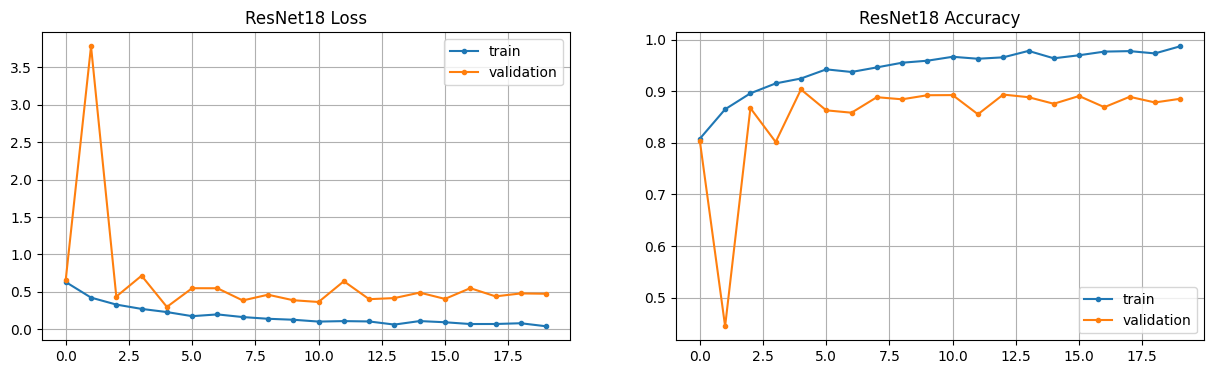


Epoch  1/20


Train Loss: 0.7884, Train Accuracy: 0.7608
      Train loss: 0.7883893190505536
  Train accuracy: 0.7607983947618545


Validation Loss: 0.8090, Validation Accuracy: 0.7419
Validation loss: 0.8089964359514112
Validation accuracy: 0.7419108280254777

Epoch  2/20


Train Loss: 0.5113, Train Accuracy: 0.8429
      Train loss: 0.5113244997085752
  Train accuracy: 0.8428556341746752


Validation Loss: 0.5489, Validation Accuracy: 0.8339
Validation loss: 0.5489211331871224
Validation accuracy: 0.8338853503184713

Epoch  3/20


Train Loss: 0.3946, Train Accuracy: 0.8736
      Train loss: 0.3945865435148212
  Train accuracy: 0.8735874960397085


Validation Loss: 0.5276, Validation Accuracy: 0.8433
Validation loss: 0.5275500168374596
Validation accuracy: 0.8433121019108281

Epoch  4/20


Train Loss: 0.3201, Train Accuracy: 0.8999
      Train loss: 0.32005115288838343
  Train accuracy: 0.8998838314499947


Validation Loss: 0.8308, Validation Accuracy: 0.7671
Validation loss: 0.8308245698368646
Validation accuracy: 0.7671337579617834

Epoch  5/20


Train Loss: 0.2791, Train Accuracy: 0.9112
      Train loss: 0.27913024048698515
  Train accuracy: 0.9111838631323266


Validation Loss: 0.4758, Validation Accuracy: 0.8632
Validation loss: 0.4757799435770366
Validation accuracy: 0.8631847133757962

Epoch  6/20


Train Loss: 0.2433, Train Accuracy: 0.9239
      Train loss: 0.24326502896115385
  Train accuracy: 0.9238567958601753


Validation Loss: 0.7237, Validation Accuracy: 0.7896
Validation loss: 0.7236755110202281
Validation accuracy: 0.7895541401273886

Epoch  7/20


Train Loss: 0.2013, Train Accuracy: 0.9366
      Train loss: 0.2012584781733568
  Train accuracy: 0.9366353363607561


Validation Loss: 0.6008, Validation Accuracy: 0.8456
Validation loss: 0.6008125450234951
Validation accuracy: 0.8456050955414013

Epoch  8/20


Train Loss: 0.1870, Train Accuracy: 0.9394
      Train loss: 0.1869983065187478
  Train accuracy: 0.93938113845179


Validation Loss: 0.4107, Validation Accuracy: 0.8739
Validation loss: 0.4107242600189719
Validation accuracy: 0.8738853503184714

Epoch  9/20


Train Loss: 0.1586, Train Accuracy: 0.9475
      Train loss: 0.15856609172250674
  Train accuracy: 0.9475129369521597


Validation Loss: 0.3836, Validation Accuracy: 0.8882
Validation loss: 0.38357410922161933
Validation accuracy: 0.8881528662420383

Epoch 10/20


Train Loss: 0.1344, Train Accuracy: 0.9561
      Train loss: 0.13436949587894315
  Train accuracy: 0.9560671665434576


Validation Loss: 0.4732, Validation Accuracy: 0.8685
Validation loss: 0.4732328698463072
Validation accuracy: 0.8685350318471338

Epoch 11/20


Train Loss: 0.1358, Train Accuracy: 0.9571
      Train loss: 0.1358105112276216
  Train accuracy: 0.9571232442707783


Validation Loss: 0.3983, Validation Accuracy: 0.8841
Validation loss: 0.39827193253104193
Validation accuracy: 0.8840764331210191

Epoch 12/20


Train Loss: 0.1174, Train Accuracy: 0.9626
      Train loss: 0.11738267680158133
  Train accuracy: 0.9626148484528462


Validation Loss: 0.4369, Validation Accuracy: 0.8851
Validation loss: 0.4368987772018082
Validation accuracy: 0.8850955414012739

Epoch 13/20


Train Loss: 0.1092, Train Accuracy: 0.9624
      Train loss: 0.10915520003638104
  Train accuracy: 0.962403632907382


Validation Loss: 0.7443, Validation Accuracy: 0.8166
Validation loss: 0.7442941969692162
Validation accuracy: 0.8165605095541402

Epoch 14/20


Train Loss: 0.1263, Train Accuracy: 0.9611
      Train loss: 0.12626995821955386
  Train accuracy: 0.9611363396345971


Validation Loss: 0.3790, Validation Accuracy: 0.8935
Validation loss: 0.37903406034882475
Validation accuracy: 0.8935031847133758

Epoch 15/20


Train Loss: 0.0712, Train Accuracy: 0.9774
      Train loss: 0.07123330795965975
  Train accuracy: 0.9773999366353363


Validation Loss: 0.3599, Validation Accuracy: 0.8986
Validation loss: 0.3599452198643003
Validation accuracy: 0.8985987261146496

Epoch 16/20


Train Loss: 0.0938, Train Accuracy: 0.9725
      Train loss: 0.0938214457836128
  Train accuracy: 0.972541979089661


Validation Loss: 0.5955, Validation Accuracy: 0.8561
Validation loss: 0.5954690144340057
Validation accuracy: 0.8560509554140128

Epoch 17/20


Train Loss: 0.0905, Train Accuracy: 0.9712
      Train loss: 0.09045481795839953
  Train accuracy: 0.9711690780441441


Validation Loss: 0.4547, Validation Accuracy: 0.8795
Validation loss: 0.45469033544716553
Validation accuracy: 0.8794904458598726

Epoch 18/20


Train Loss: 0.0650, Train Accuracy: 0.9771
      Train loss: 0.06496556647530147
  Train accuracy: 0.9770831133171402


Validation Loss: 0.3740, Validation Accuracy: 0.9014
Validation loss: 0.37399267555664983
Validation accuracy: 0.9014012738853503

Epoch 19/20


Train Loss: 0.0694, Train Accuracy: 0.9779
      Train loss: 0.06938146549529503
  Train accuracy: 0.9779279754989967


Validation Loss: 0.4161, Validation Accuracy: 0.8871
Validation loss: 0.4161307972144124
Validation accuracy: 0.8871337579617834

Epoch 20/20


Train Loss: 0.0747, Train Accuracy: 0.9756
      Train loss: 0.07471561368721588
  Train accuracy: 0.9756046044988911


Validation Loss: 0.7590, Validation Accuracy: 0.8380
Validation loss: 0.7589715863331941
Validation accuracy: 0.8379617834394905


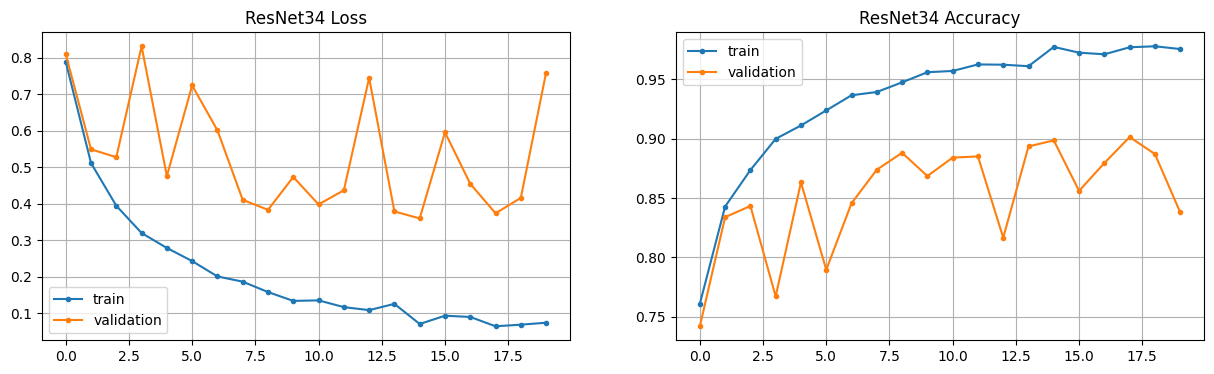


Epoch  1/20


Train Loss: 0.3685, Train Accuracy: 0.8968
      Train loss: 0.3685394207619735
  Train accuracy: 0.8968212060407647


Validation Loss: 0.2155, Validation Accuracy: 0.9383
Validation loss: 0.21545948808808335
Validation accuracy: 0.938343949044586

Epoch  2/20


Train Loss: 0.1913, Train Accuracy: 0.9433
      Train loss: 0.19129053100540833
  Train accuracy: 0.9432886260428768


Validation Loss: 0.1475, Validation Accuracy: 0.9511
Validation loss: 0.14747560118322453
Validation accuracy: 0.9510828025477707

Epoch  3/20


Train Loss: 0.1590, Train Accuracy: 0.9477
      Train loss: 0.15903538620772747
  Train accuracy: 0.9477241524976239


Validation Loss: 0.1940, Validation Accuracy: 0.9406
Validation loss: 0.19402853122827637
Validation accuracy: 0.9406369426751592

Epoch  4/20


Train Loss: 0.1318, Train Accuracy: 0.9607
      Train loss: 0.13184229540245332
  Train accuracy: 0.9607139085436688


Validation Loss: 0.1801, Validation Accuracy: 0.9447
Validation loss: 0.18014844055703985
Validation accuracy: 0.9447133757961783

Epoch  5/20


Train Loss: 0.1203, Train Accuracy: 0.9628
      Train loss: 0.12025345903365067
  Train accuracy: 0.9628260639983103


Validation Loss: 0.1628, Validation Accuracy: 0.9496
Validation loss: 0.1627878228266822
Validation accuracy: 0.9495541401273885

Epoch  6/20


Train Loss: 0.0940, Train Accuracy: 0.9707
      Train loss: 0.09397462046763394
  Train accuracy: 0.9707466469532158


Validation Loss: 0.1923, Validation Accuracy: 0.9447
Validation loss: 0.19229419197523473
Validation accuracy: 0.9447133757961783

Epoch  7/20


Train Loss: 0.0951, Train Accuracy: 0.9699
      Train loss: 0.0950777701336601
  Train accuracy: 0.9699017847713591


Validation Loss: 0.2021, Validation Accuracy: 0.9396
Validation loss: 0.20214667328116598
Validation accuracy: 0.9396178343949044

Epoch  8/20


Train Loss: 0.0877, Train Accuracy: 0.9722
      Train loss: 0.08772708294910027
  Train accuracy: 0.9722251557714647


Validation Loss: 0.2651, Validation Accuracy: 0.9325
Validation loss: 0.2650796608667872
Validation accuracy: 0.932484076433121

Epoch  9/20


Train Loss: 0.0697, Train Accuracy: 0.9791
      Train loss: 0.06966031229554524
  Train accuracy: 0.9790896609990495


Validation Loss: 0.2199, Validation Accuracy: 0.9391
Validation loss: 0.21991825137561175
Validation accuracy: 0.9391082802547771

Epoch 10/20


Train Loss: 0.0751, Train Accuracy: 0.9756
      Train loss: 0.07507981171707993
  Train accuracy: 0.9756046044988911


Validation Loss: 0.1711, Validation Accuracy: 0.9498
Validation loss: 0.17107825639113725
Validation accuracy: 0.9498089171974522

Epoch 11/20


Train Loss: 0.0616, Train Accuracy: 0.9827
      Train loss: 0.06156793917398318
  Train accuracy: 0.98268032527194


Validation Loss: 0.1874, Validation Accuracy: 0.9475
Validation loss: 0.18738312243291827
Validation accuracy: 0.947515923566879

Epoch 12/20


Train Loss: 0.0806, Train Accuracy: 0.9747
      Train loss: 0.08060742188024812
  Train accuracy: 0.9746541345443025


Validation Loss: 0.2049, Validation Accuracy: 0.9439
Validation loss: 0.20485519377961453
Validation accuracy: 0.9439490445859873

Epoch 13/20


Train Loss: 0.0649, Train Accuracy: 0.9793
      Train loss: 0.06494306122437371
  Train accuracy: 0.9793008765445137


Validation Loss: 0.1987, Validation Accuracy: 0.9473
Validation loss: 0.19869607136793757
Validation accuracy: 0.9472611464968153

Epoch 14/20


Train Loss: 0.0565, Train Accuracy: 0.9823
      Train loss: 0.0565219376848954
  Train accuracy: 0.9822578941810117


Validation Loss: 0.2219, Validation Accuracy: 0.9445
Validation loss: 0.2219407931775871
Validation accuracy: 0.9444585987261146

Epoch 15/20


Train Loss: 0.0585, Train Accuracy: 0.9805
      Train loss: 0.058505704037088435
  Train accuracy: 0.9804625620445665


Validation Loss: 0.2038, Validation Accuracy: 0.9493
Validation loss: 0.2038001751248308
Validation accuracy: 0.9492993630573249

Epoch 16/20


Train Loss: 0.0508, Train Accuracy: 0.9836
      Train loss: 0.05076351299750378
  Train accuracy: 0.9836307952265286


Validation Loss: 0.1894, Validation Accuracy: 0.9498
Validation loss: 0.18935982222298137
Validation accuracy: 0.9498089171974522

Epoch 17/20


Train Loss: 0.0641, Train Accuracy: 0.9798
      Train loss: 0.06408657546052308
  Train accuracy: 0.9798289154081741


Validation Loss: 0.1923, Validation Accuracy: 0.9496
Validation loss: 0.19231406059095124
Validation accuracy: 0.9495541401273885

Epoch 18/20


Train Loss: 0.0588, Train Accuracy: 0.9816
      Train loss: 0.05877275528375223
  Train accuracy: 0.9816242475446193


Validation Loss: 0.1678, Validation Accuracy: 0.9524
Validation loss: 0.167826472097888
Validation accuracy: 0.9523566878980891

Epoch 19/20


Train Loss: 0.0448, Train Accuracy: 0.9844
      Train loss: 0.0447995149975582
  Train accuracy: 0.9843700496356532


Validation Loss: 0.1828, Validation Accuracy: 0.9496
Validation loss: 0.18278508929435472
Validation accuracy: 0.9495541401273885

Epoch 20/20


Train Loss: 0.0419, Train Accuracy: 0.9871
      Train loss: 0.04188436389228406
  Train accuracy: 0.987115851726687


Validation Loss: 0.2309, Validation Accuracy: 0.9396
Validation loss: 0.23093661580509714
Validation accuracy: 0.9396178343949044


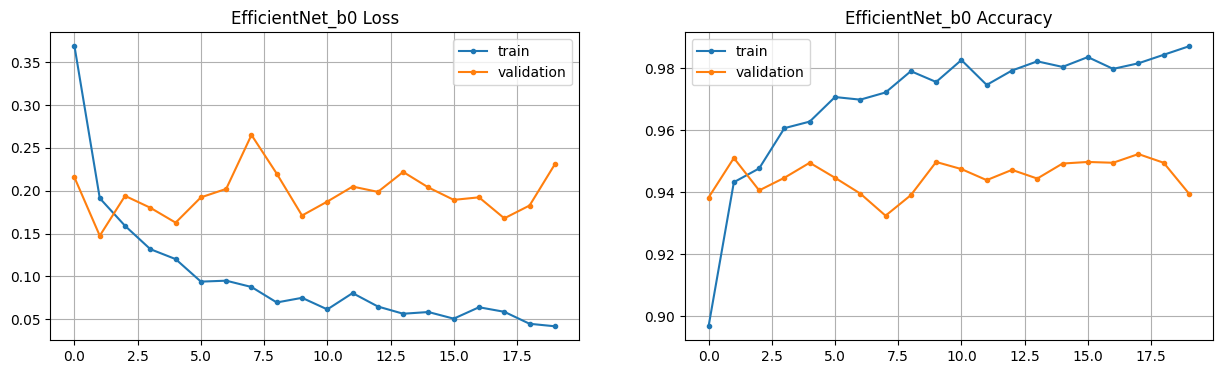

AttributeError: 'MobileNetV2' object has no attribute 'fc'

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

models_to_try = [
    (models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1), "ResNet18"),
    (models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1), "ResNet34"),
    (models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1), "EfficientNet_b0")
]

results = {}

for model, name in models_to_try:
    if isinstance(model, models.EfficientNet):
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_labels)
    else:
        model.fc = nn.Linear(model.fc.in_features, num_labels)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    n_epochs = 20
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    best_acc = 0.0
    for ep in range(n_epochs):
        print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")
        train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        train_losses.append(train_logs["loss"])
        train_accuracies.append(train_logs["accuracy"])
        print("      Train loss:", train_losses[-1])
        print("  Train accuracy:", train_accuracies[-1])

        valid_logs = evaluate(model, valid_loader, loss_fn, device)
        valid_losses.append(valid_logs["eval_loss"])
        valid_accuracies.append(valid_logs["accuracy"])
        print("Validation loss:", valid_losses[-1])
        print("Validation accuracy:", valid_accuracies[-1])

        if valid_logs["accuracy"] > best_acc:
            best_acc = valid_logs["accuracy"]

    results[name] = best_acc

    # Візуалізація
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
    axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
    axes[0].legend(["train", "validation"])
    axes[0].set_title(f"{name} Loss")
    axes[0].grid()

    axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
    axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
    axes[1].legend(["train", "validation"])
    axes[1].set_title(f"{name} Accuracy")
    axes[1].grid()
    plt.show()

In [1]:
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")
print("Найкраща модель:", max(results, key=results.get))

NameError: name 'results' is not defined